# Fourier Propagation of a 1‑D Gaussian Beam
This notebook shows how to  

1. Define a Fourier transfer‑function propagator.  
2. Generate a 1‑D Gaussian intensity profile and its complex field.  
3. Propagate the field over a range of distances.  
4. Extract the RMS beam size and compare it with the analytical diffraction‑limited model.  
5. Explore how the initial waist influences the beam after 1 m.  
6. Visualise the full 2‑D intensity evolution (x‑z diagram).  

**Author:** Rachel Migdal – 24 September 2025

1) Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt

2) Fourier Propagation Transfer Function
The function `propTF` implements the Fourier transfer function in the spatial‑frequency domain.
Inputs

* `uin_V_m` – complex field on the input plane (1‑D array)  
* `L_m` – transverse window size (m)  
* `lambda_m` – wavelength (m)  
* `z_m` – propagation distance (m)

Output – complex field on the output plane.  

In [17]:
def propTF(uin_V_m, L_m, lambda_m, z_m):
    M = uin_V_m.size        # number of samples (grid points)
    dx_m = L_m/M            # grid spacing
    k_1_m = 2*np.pi/lambda_m # wavenumber

    # Frequency coordinates
    fx_1_m = np.linspace(-1/(2*dx_m), 1/(2*dx_m) - (1/L_m), M)
    
    # Transfer function for Fresnel propagation
    H = np.exp(-1j * np.pi * lambda_m * z_m * (fx_1_m**2))
    H = np.fft.fftshift(H)

    # Fourier transform input field
    Uin_V_m = np.fft.fft(np.fft.fftshift(uin_V_m))

    # Multiply in Fourier space
    Uout_V_m = H * Uin_V_m

    # Inverse FFT → propagated field
    uout_V_m = np.fft.ifftshift(np.fft.ifft(Uout_V_m))
    return uout_V_m

3) Define the Spatial Grid and Initial Gaussian Beam
A 1‑m transverse window with 1‑µm sampling gives 1 000 001 points.  
The Gaussian intensity is  

$
I(x)=\exp\!\Big[-\frac{(x-x_0)^2}{2\sigma^2}\Big],$

with `σ = 50 µm`.  
The complex field is the square‑root of the intensity.  

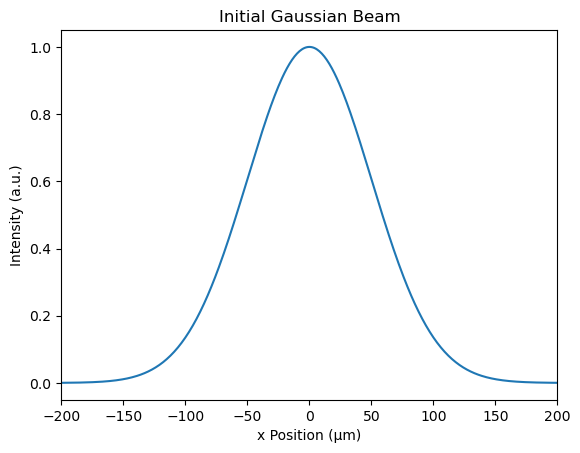

In [18]:
dx_m = 1e-6                                          # grid size, m:meter
Dx_m = 1                                             # screen size
x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m)+1) # spatial grid along x-axis 

x_mean_m = 0.0                                       # centered on...
x_std_m = 50e-6                                      # width of gaussian
g = np.exp(-(x_m - x_mean_m)**2/(2*(x_std_m**2)))    # gaussian intensity distribution

plt.plot(x_m*1e6, g, color='tab:blue')
plt.xlabel("x Position (µm)")
plt.ylabel('Intensity (a.u.)') 
plt.title('Initial Gaussian Beam')
plt.xlim(-200, 200)
plt.show()

4) Propagate a Single Distance (z = 100 mm) and Visualise

We propagate the field by 0.1 m, compute the intensity, and plot the result.  


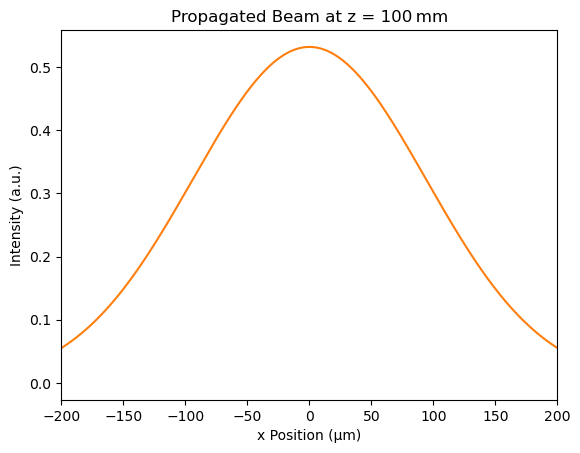

In [19]:
wavelength_m = 500e-9 
zp_m = 100e-3                             # propagation distance, m

E0 = np.sqrt(g)                           # initial field amplitude squared = Gaussian intensity 
Ep = propTF(E0, Dx_m, wavelength_m, zp_m) # propTF propagates that field forward by a distance zp_m 

Ip = np.abs(Ep)**2                        # intensity 

plt.plot(x_m*1e6, Ip, color='tab:orange')
plt.xlabel("x Position (µm)")
plt.ylabel('Intensity (a.u.)') 
plt.title(f'Propagated Beam at z = {zp_m*1e3:.0f} mm')
plt.xlim(-200, 200)
plt.show()


5) Beam‑Size vs. Propagation Distance (Positive z)

For each distance we compute the RMS beam size from the intensity moments and store the results.  

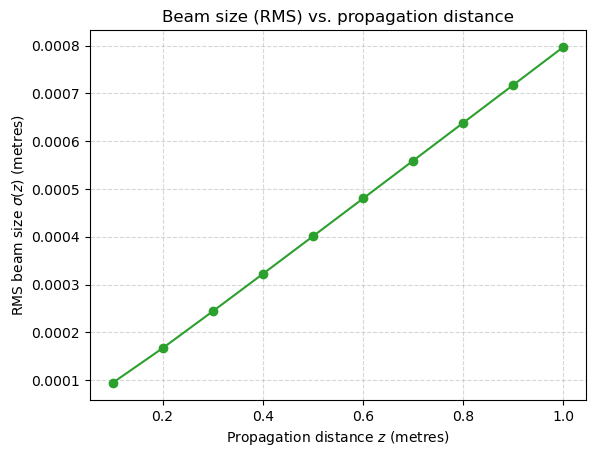

In [20]:
wavelength_m = 500e-9         # 500 nm
dx_m         = 1e-6           # transverse sampling (1 µm)
Dx_m         = 1.0            # total transverse window (1 m)

x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m) + 1)

sigma0_m = 50e-6
g = np.exp(-(x_m**2) / (2 * sigma0_m**2))   # intensity profile
E0 = np.sqrt(g)                            # complex field (real-valued)

beam_sizes_m = []    # RMS beam size σ(z)  
distances_m   = []   # propagation distance z 

# Loop over propagation distances 
for z_mm in range(100, 1100, 100):          # 100 mm … 1000 mm
    z_m = z_mm * 1e-3                       

    Ez = propTF(E0, Dx_m, wavelength_m, z_m)
    Iz = np.abs(Ez)**2                      # intensity

    # RMS beam size from intensity moments 
    x_mean = np.sum(x_m * Iz) / np.sum(Iz)

    # Weighted standard deviation (RMS radius)
    sigma_z = np.sqrt(np.sum((x_m - x_mean)**2 * Iz) / np.sum(Iz))

    beam_sizes_m.append(sigma_z)
    distances_m.append(z_m)

plt.figure()
plt.plot(distances_m, beam_sizes_m, 'o-', color='tab:green')
plt.title('Beam size (RMS) vs. propagation distance')
plt.xlabel('Propagation distance $z$ (metres)')
plt.ylabel('RMS beam size $\\sigma(z)$ (metres)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

6) Theoretical Diffraction‑Limited Beam Size  
For a Gaussian with RMS waist \(\sigma_{0}\) the paraxial law is  

$$
\sigma(z)=\sqrt{\sigma_{0}^{2}+(\theta\,z)^{2}},\qquad
\theta=\frac{\lambda}{4\pi\,\sigma_{0}}
$$

where $\theta$ is the RMS divergence (rad).  
We overlay the analytical curve on the simulated data.  


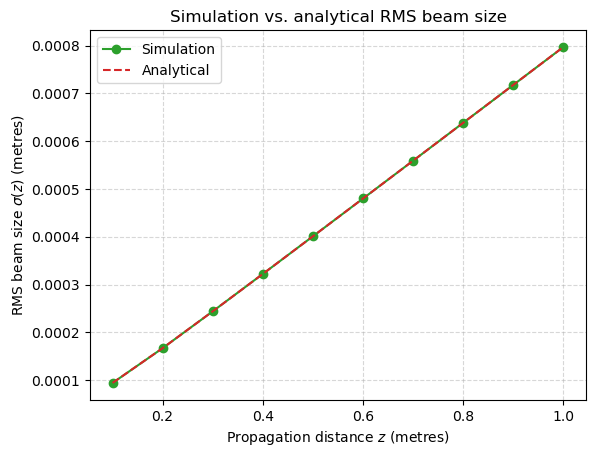

In [27]:
theta = wavelength_m / (4 * np.pi * sigma0_m)

# Analytical σ(z) evaluated at the same distances used in the simulation
sigma_theory = np.sqrt(sigma0_m**2 + (theta * np.array(distances_m))**2)

plt.figure()
plt.plot(distances_m, beam_sizes_m, 'o-', color='tab:green',
         label='Simulation')
plt.plot(distances_m, sigma_theory, '--', color='tab:red',
         label='Analytical')
plt.title('Simulation vs. analytical RMS beam size')
plt.xlabel('Propagation distance $z$ (metres)')
plt.ylabel('RMS beam size $\\sigma(z)$ (metres)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()

7) Effect of Initial Beam Waist on the Beam After **z = 1 m**  

Sweep the initial waist from 20 µm to 100 µm, propagate to 1 m, and record the output RMS size.

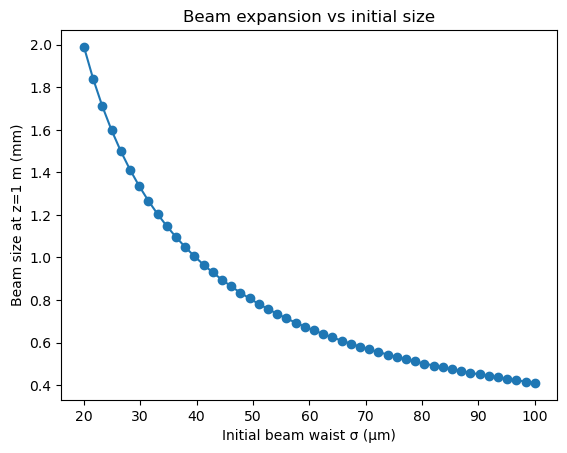

In [28]:
beam_waists_m = np.linspace(20e-6, 100e-6, 50)  # initial sizes
beam_size_at_1m = []

for i in beam_waists_m:
    g = np.exp(-(x_m**2)/(2*i**2))   # Gaussian intensity
    E0 = np.sqrt(g)                      # field amplitude
    
    Ep = propTF(E0, Dx_m, wavelength_m, 1.0)  # propagate to z=1 m
    Ip = np.abs(Ep)**2
    
    # Compute beam size
    x_mean = np.sum(x_m * Ip) / np.sum(Ip)  # center of mass
    x_std = np.sqrt(np.sum((x_m - x_mean)**2 * Ip) / np.sum(Ip))
    beam_size_at_1m.append(x_std)

plt.figure()
plt.plot(np.array(beam_waists_m)*1e6, np.array(beam_size_at_1m)*1e3, 'o-')
plt.xlabel("Initial beam waist σ (µm)")
plt.ylabel("Beam size at z=1 m (mm)")
plt.title("Beam expansion vs initial size")
plt.show()

8) Full 2‑D Beam Evolution (x–z Diagram)  

Compute the intensity for many propagation distances (negative → positive) and display it with `imshow`.  

All axes are in meters.  

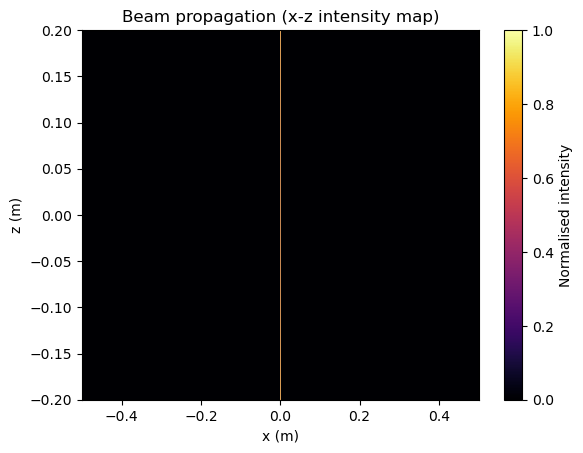

In [29]:
# Longitudinal range (‑0.2 m … +0.2 m)
Z_m = np.linspace(-0.2, 0.2, 200)
I_zx = []                              # list of intensity slices

for z in Z_m:
    E = propTF(E0, Dx_m, wavelength_m, z)
    I = np.abs(E)**2
    I = I / I.max()                    # normalise for visual contrast
    I_zx.append(I)

I_zx = np.array(I_zx)                  # shape (len(Z), len(x))

plt.figure()
plt.imshow(I_zx,
           extent=[x_m[0], x_m[-1], Z_m[0], Z_m[-1]],
           aspect='auto',
           cmap='inferno',
           origin='lower')
plt.colorbar(label='Normalised intensity')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Beam propagation (x‑z intensity map)')
plt.show()

9) Negative Propagation Distances (**z < 0**)  

Repeat the RMS‑size extraction for negative distances to verify symmetry about the waist.  

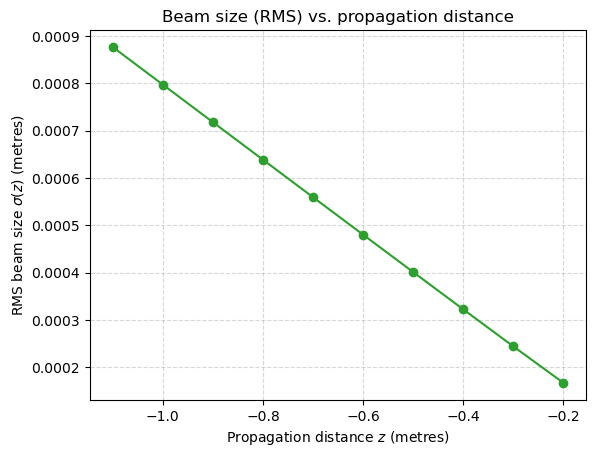

In [31]:
wavelength_m = 500e-9         # 500 nm
dx_m         = 1e-6           # transverse sampling (1 µm)
Dx_m         = 1.0            # total transverse window (1 m)

x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m) + 1)

sigma0_m = 50e-6
g = np.exp(-(x_m**2) / (2 * sigma0_m**2))   # intensity profile
E0 = np.sqrt(g)                            # complex field (real-valued)

beam_sizes_m = []    # RMS beam size σ(z)  
distances_m   = []   # propagation distance z 

# Loop over propagation distances 
for z_mm in range(-1100,-100, 100):          # -1100 mm … -100 mm
    z_m = z_mm * 1e-3                       

    Ez = propTF(E0, Dx_m, wavelength_m, z_m)
    Iz = np.abs(Ez)**2                      # intensity

    # RMS beam size from intensity moments 
    x_mean = np.sum(x_m * Iz) / np.sum(Iz)

    # Weighted standard deviation (RMS radius)
    sigma_z = np.sqrt(np.sum((x_m - x_mean)**2 * Iz) / np.sum(Iz))

    beam_sizes_m.append(sigma_z)
    distances_m.append(z_m)

plt.figure()
plt.plot(distances_m, beam_sizes_m, 'o-', color='tab:green')
plt.title('Beam size (RMS) vs. propagation distance')
plt.xlabel('Propagation distance $z$ (metres)')
plt.ylabel('RMS beam size $\\sigma(z)$ (metres)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

10) Analytical Beam‑Size Model & Comparison with Simulation  

• **Generate** the same 1‑D Gaussian field used earlier.  
• **Propagate** it over a symmetric range of distances (‑1.1 m → +1.1 m) with the Fresnel transfer function `propTF`.  
• **Extract** the RMS beam size from the simulated intensity (`σ_sim(z)`).  
• **Compute** the analytical RMS size for a diffraction‑limited Gaussian beam where `σ₀` is the initial RMS waist.


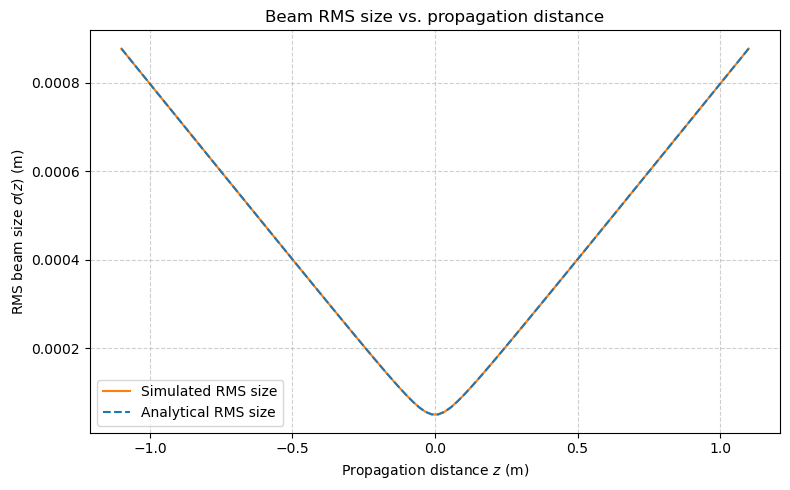

In [33]:
wavelength_m = 500e-9          # 500 nm
dx_m         = 1e-6           # transverse sampling (1 µm)
Dx_m         = 1.0            # transverse window (1 m)

x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m) + 1)

sigma0_m = 50e-6               # 50 µm
I0 = np.exp(-(x_m**2) / (2 * sigma0_m**2))   # intensity profile
E0 = np.sqrt(I0)               # field amplitude (real‑valued)

Z_m = np.linspace(-1.1, 1.1, 100)   # from –1.1 m to +1.1 m

sim_beam_sizes_m = []
Ixz = np.zeros((len(Z_m), len(x_m)))   # normalized intensity vs (z,x)

for idx, z in enumerate(Z_m):
    Ez = propTF(E0, Dx_m, wavelength_m, z)
    Iz = np.abs(Ez)**2

    # Normalise each slice for visualisation (max = 1)
    Iz_norm = Iz / Iz.max()
    Ixz[idx, :] = Iz_norm

    # RMS beam size from intensity‑weighted second moment
    x_mean = np.sum(x_m * Iz) / np.sum(Iz)
    sigma_z = np.sqrt(np.sum((x_m - x_mean)**2 * Iz) / np.sum(Iz))
    sim_beam_sizes_m.append(sigma_z)

sim_beam_sizes_m = np.array(sim_beam_sizes_m)   # (N_z,)

#  Analytical RMS beam size 
theta_rad = wavelength_m / (4 * np.pi * sigma0_m)    # RMS divergence (rad)
sigma_th_m = np.sqrt(sigma0_m**2 + (theta_rad * Z_m)**2)

plt.figure(figsize=(8, 5))
plt.plot(Z_m, sim_beam_sizes_m,
         label='Simulated RMS size', color='tab:orange')
plt.plot(Z_m, sigma_th_m,
         '--', label='Analytical RMS size', color='tab:blue')
plt.xlabel('Propagation distance $z$ (m)')
plt.ylabel('RMS beam size $\\sigma(z)$ (m)')
plt.title('Beam RMS size vs. propagation distance')
plt.grid(True, ls='--', alpha=0.6)


plt.legend()
plt.tight_layout()
plt.show()

11) Plot the 2‑D intensity evolution (x‑z diagram)

Z was defined in the previous cell as the propagation‑distance vector (m)

Ixz has shape (len(Z), len(x_m)) and already contains the **normalized** intensity for each slice.

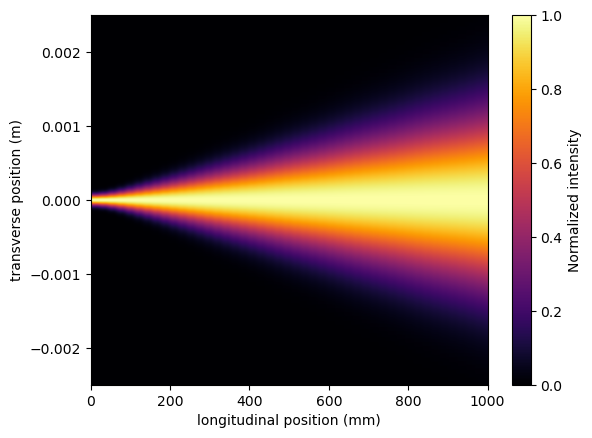

In [35]:
# Transpose so that the first dimension (z) runs horizontally.
plt.imshow(np.transpose(Ixz),
           extent=[Z_m[0]*1e3, Z_m[-1]*1e3,x_m[0], x_m[-1]],
           aspect='auto',
           cmap='inferno')
plt.ylim([-0.0025, 0.0025])
plt.xlabel("longitudinal position (mm)")
plt.ylabel("transverse position (m)")
plt.xlim([0,1000])
plt.colorbar(label='Normalized intensity')
plt.show()            
